In [1]:
# All libs be imported
import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Setup Logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [2]:
""" All files in src directory """
from market_processing import *
from entities import *

In [3]:
from engine import Engine
from models import DiffusionTransformer
from frameworks import Diffusion

device = "cuda" if torch.cuda.is_available() else "cpu"
window_size = 64
batch_size = 32
epochs = 20
lr = 1e-4
hiden_dim = 128
deep_layers = 2
n_attention_head = 4
ddpm = {
    "noise_steps": 1000,
    "beta_start": 1e-4,
    "beta_end": 0.02,
}

In [4]:
symbols = ['AAPL', 'TSLA', 'MSFT']
basket = AssetBasket(symbols=symbols)
window_size = 64

DEBUG:entities.basket:Initialized Asset Basket: ['AAPL', 'TSLA', 'MSFT'] with 0 assets which loaded.


In [5]:
basket.load_all_assets(freq="1d")

for symbol, asset in basket.assets.items():
    asset.to_returns(log=True, target_features=['Close'])
    vol_series = asset.get_garman_klass_vol(look_back=window_size, annualized=False)
    asset.data[f"Vol_{symbol}"] = vol_series

basket.get_stats_summary()

INFO:entities.basket:Starting batch load for 3 symbols...
DEBUG:entities.basket:Attempting to load AAPL...
DEBUG:entities.asset:Initialized Asset: AAPL with 2724 rows.
INFO:entities.basket:Successfully loaded AAPL (2724 rows).
DEBUG:entities.basket:Attempting to load TSLA...
DEBUG:entities.asset:Initialized Asset: TSLA with 2760 rows.
INFO:entities.basket:Successfully loaded TSLA (2760 rows).
DEBUG:entities.basket:Attempting to load MSFT...
DEBUG:entities.asset:Initialized Asset: MSFT with 2724 rows.
INFO:entities.basket:Successfully loaded MSFT (2724 rows).
INFO:entities.basket:Batch load complete. Success: 3/3. Total assets in basket: 3
DEBUG:entities.asset:AAPL converted to Returns (Log=True)
DEBUG:entities.asset:TSLA converted to Returns (Log=True)
DEBUG:entities.asset:MSFT converted to Returns (Log=True)


,count,mean,std,min,25%,50%,75%,max,skew,kurt
symbol,,,,,,,,,,
AAPL,2723.0,0.000887,0.018264,-0.137708,-0.007422,0.001000,0.010039,0.142617,-0.091082,6.281809
TSLA,2759.0,0.001272,0.036304,-0.236518,-0.016660,0.001261,0.019425,0.204491,-0.056569,4.357829
MSFT,2723.0,0.000947,0.016983,-0.159454,-0.006668,0.000958,0.009423,0.132929,-0.098976,8.165358
TOTAL_AVG,8205.0,0.001035,0.023850,-0.177893,-0.010250,0.001073,0.012962,0.160012,-0.082209,6.268332


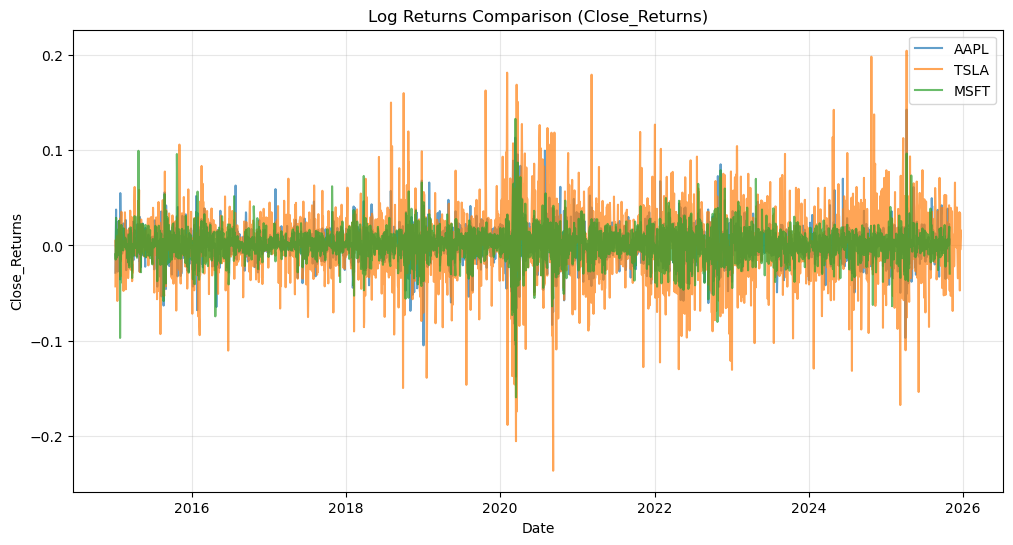

In [6]:
basket.plot_assets(title='Log Returns Comparison')

In [16]:
# strategy = StrictAlignment()
strategy = MarketFeatureAlignment()
joint_df = basket.get_joint_data(strategy)
joint_df.head()

DEBUG:market_processing.strategies.concrete:Symbol: AAPL, DataFrame Column Names: ['Close', 'High', 'Low', 'Open', 'Volume', 'Close_Returns', 'Vol_AAPL'], Selected Columns: ['Close_Returns', 'Vol_AAPL']
DEBUG:market_processing.strategies.concrete:Symbol: TSLA, DataFrame Column Names: ['Close', 'High', 'Low', 'Open', 'Volume', 'Close_Returns', 'Vol_TSLA'], Selected Columns: ['Close_Returns', 'Vol_TSLA']
DEBUG:market_processing.strategies.concrete:Symbol: MSFT, DataFrame Column Names: ['Close', 'High', 'Low', 'Open', 'Volume', 'Close_Returns', 'Vol_MSFT'], Selected Columns: ['Close_Returns', 'Vol_MSFT']
DEBUG:entities.basket:Aligned data shape: (2660, 6)


,AAPL_Close_Returns,Vol_AAPL,TSLA_Close_Returns,Vol_TSLA,MSFT_Close_Returns,Vol_MSFT
Date,,,,,,
2015-04-07,-0.010578,0.012762,0.000738,0.020798,-0.000481,0.011548
2015-04-08,-0.003259,0.012605,0.021514,0.020604,-0.002652,0.011595
2015-04-09,0.007614,0.012455,0.011586,0.020243,0.001447,0.011447
2015-04-10,0.004258,0.012455,0.003848,0.020182,0.005770,0.011359
2015-04-13,-0.001969,0.012328,-0.005325,0.020202,0.000958,0.011348


In [17]:
selected = ["AAPL_Close_Returns", "TSLA_Close_Returns", "MSFT_Close_Returns"]
joint_df = joint_df[selected]
joint_df.head()

,AAPL_Close_Returns,TSLA_Close_Returns,MSFT_Close_Returns
Date,,,
2015-04-07,-0.010578,0.000738,-0.000481
2015-04-08,-0.003259,0.021514,-0.002652
2015-04-09,0.007614,0.011586,0.001447
2015-04-10,0.004258,0.003848,0.005770
2015-04-13,-0.001969,-0.005325,0.000958


In [18]:
# # 2. Align Data (รวมร่าง)
#     # ใช้ StrictAlignment เพื่อเอาเฉพาะวันที่ตลาดเปิดตรงกัน

    
#     print(f"Joint Data Shape: {joint_df.shape}")
#     # columns จะเป็น [AAPL_Close_ret, MSFT_Close_ret]
    
#     # 3. Preprocess for Model (Scale & Window)
#     processor = MarketPreprocessor(window_size=60, train_split=0.8)
#     X_train, X_test = processor.fit_transform(joint_df)

In [19]:
dm = MarketDataModule(
        joint_df=joint_df,
        window_size=window_size,
        batch_size=batch_size,
        use_stats_features=False,
        split_ratio=(0.7, 0.2, 0.1)
    )

In [20]:
dm.setup()

INFO:market_processing.data_module:Setting up MarketDataModule...
DEBUG:market_processing.data_module: Use states featyres: False, DataFrame Index: DatetimeIndex(['2015-04-07', '2015-04-08', '2015-04-09', '2015-04-10',
               '2015-04-13', '2015-04-14', '2015-04-15', '2015-04-16',
               '2015-04-17', '2015-04-20',
               ...
               '2025-10-17', '2025-10-20', '2025-10-21', '2025-10-22',
               '2025-10-23', '2025-10-24', '2025-10-27', '2025-10-28',
               '2025-10-29', '2025-10-30'],
              dtype='datetime64[ns]', name='Date', length=2660, freq=None), Num of DataFrame: 2660
DEBUG:market_processing.data_module: Num of Data: 2660
DEBUG:market_processing.data_module: Split sizes - Train: 1861, Val: 532, Test: 267
INFO:market_processing.data_module: MarketDataModule setup complete.


In [22]:
dm._clean_and_inspect_features(dm.df)

INFO:market_processing.data_module:====== Inspection: Data ======
INFO:market_processing.data_module:  > Shape: (2660, 3)
INFO:market_processing.data_module:  > Columns: [AAPL, TSLA, MSFT]
DEBUG:market_processing.data_module:  > Head (First 3 rows):
                AAPL      TSLA      MSFT
Date                                    
2015-04-07 -0.010578  0.000738 -0.000481
2015-04-08 -0.003259  0.021514 -0.002652
2015-04-09  0.007614  0.011586  0.001447
INFO:market_processing.data_module:===================================


,AAPL,TSLA,MSFT
Date,,,
2015-04-07,-0.010578,0.000738,-0.000481
2015-04-08,-0.003259,0.021514,-0.002652
2015-04-09,0.007614,0.011586,0.001447
2015-04-10,0.004258,0.003848,0.005770
2015-04-13,-0.001969,-0.005325,0.000958
...,...,...,...
2025-10-24,0.012405,-0.034579,0.005842
2025-10-27,0.022535,0.042212,0.014994
2025-10-28,0.000707,0.017810,0.019654


In [23]:
train_dataloader = dm.train_dataloader()
val_dataloader = dm.validate_dataloader()
test_dataloader = dm.test_dataloader()

X, y = next(iter(train_dataloader))
y.shape

torch.Size([32, 64, 3])

In [24]:
model = DiffusionTransformer(
    features_in=X.shape[2],
    d_model=hiden_dim,
    num_layers=deep_layers,
    nhead=n_attention_head,
    max_len=window_size
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr) 
diffusion = Diffusion(
    noise_steps = ddpm["noise_steps"],
    beta_start = ddpm["beta_start"],
    beta_end = ddpm["beta_end"],
    length= window_size,
    channels= X.shape[2],
    device = device
)

In [25]:
engine = Engine(train_dataloader= train_dataloader, val_dataloader=val_dataloader, test_dataloader=test_dataloader, diffusion=diffusion, model=model, optimizer=optimizer, num_epochs_to_save=epochs/2 ,device=device)
engine.fit(epochs=epochs)

history = engine.history

INFO:engine:Engine started! Training for 20 epochs on cuda...
Epoch 0/20: 100%|██████████| 57/57 [00:01<00:00, 46.16it/s, MSELoss=0.3000]
INFO:engine:Epoch 1 | Train Loss: 0.337670 | Val Loss: 0.214375
INFO:root:New Best Model Found! (Val Loss: 0.214375)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0001_20260108_183614.pt


Epoch 1/20: 100%|██████████| 57/57 [00:00<00:00, 82.30it/s, MSELoss=0.2409]
INFO:engine:Epoch 2 | Train Loss: 0.280373 | Val Loss: 0.303127
Epoch 2/20: 100%|██████████| 57/57 [00:00<00:00, 82.55it/s, MSELoss=0.3039]
INFO:engine:Epoch 3 | Train Loss: 0.268665 | Val Loss: 0.246575
Epoch 3/20: 100%|██████████| 57/57 [00:00<00:00, 82.59it/s, MSELoss=0.2626]
INFO:engine:Epoch 4 | Train Loss: 0.272058 | Val Loss: 0.181460
INFO:root:New Best Model Found! (Val Loss: 0.181460)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0004_20260108_183617.pt


Epoch 4/20: 100%|██████████| 57/57 [00:00<00:00, 82.29it/s, MSELoss=0.4547]
INFO:engine:Epoch 5 | Train Loss: 0.247307 | Val Loss: 0.249466
Epoch 5/20: 100%|██████████| 57/57 [00:00<00:00, 82.67it/s, MSELoss=0.3254]
INFO:engine:Epoch 6 | Train Loss: 0.251299 | Val Loss: 0.275299
Epoch 6/20: 100%|██████████| 57/57 [00:00<00:00, 82.61it/s, MSELoss=0.3246]
INFO:engine:Epoch 7 | Train Loss: 0.264407 | Val Loss: 0.165891
INFO:root:New Best Model Found! (Val Loss: 0.165891)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0007_20260108_183619.pt


Epoch 7/20: 100%|██████████| 57/57 [00:00<00:00, 82.49it/s, MSELoss=0.3353]
INFO:engine:Epoch 8 | Train Loss: 0.264469 | Val Loss: 0.212312
Epoch 8/20: 100%|██████████| 57/57 [00:00<00:00, 82.84it/s, MSELoss=0.0747]
INFO:engine:Epoch 9 | Train Loss: 0.251984 | Val Loss: 0.200021
Epoch 9/20: 100%|██████████| 57/57 [00:00<00:00, 82.73it/s, MSELoss=0.1725]
INFO:engine:Epoch 10 | Train Loss: 0.248061 | Val Loss: 0.218797
Epoch 10/20: 100%|██████████| 57/57 [00:00<00:00, 81.33it/s, MSELoss=0.1275]
INFO:engine:Epoch 11 | Train Loss: 0.246971 | Val Loss: 0.167930
Epoch 11/20: 100%|██████████| 57/57 [00:00<00:00, 80.09it/s, MSELoss=0.2072]
INFO:engine:Epoch 12 | Train Loss: 0.263246 | Val Loss: 0.243304
Epoch 12/20: 100%|██████████| 57/57 [00:00<00:00, 80.25it/s, MSELoss=0.2243]
INFO:engine:Epoch 13 | Train Loss: 0.231767 | Val Loss: 0.148371
INFO:root:New Best Model Found! (Val Loss: 0.148371)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0013_20260108_183623.pt


Epoch 13/20: 100%|██████████| 57/57 [00:00<00:00, 80.24it/s, MSELoss=0.2671]
INFO:engine:Epoch 14 | Train Loss: 0.247439 | Val Loss: 0.083884
INFO:root:New Best Model Found! (Val Loss: 0.083884)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0014_20260108_183624.pt


Epoch 14/20: 100%|██████████| 57/57 [00:00<00:00, 79.82it/s, MSELoss=0.2676]
INFO:engine:Epoch 15 | Train Loss: 0.246262 | Val Loss: 0.181616
Epoch 15/20: 100%|██████████| 57/57 [00:00<00:00, 80.19it/s, MSELoss=0.1375]
INFO:engine:Epoch 16 | Train Loss: 0.241296 | Val Loss: 0.197290
Epoch 16/20: 100%|██████████| 57/57 [00:00<00:00, 80.28it/s, MSELoss=0.2174]
INFO:engine:Epoch 17 | Train Loss: 0.245794 | Val Loss: 0.197298
Epoch 17/20: 100%|██████████| 57/57 [00:00<00:00, 80.26it/s, MSELoss=0.3081]
INFO:engine:Epoch 18 | Train Loss: 0.257932 | Val Loss: 0.189479
Epoch 18/20: 100%|██████████| 57/57 [00:00<00:00, 80.65it/s, MSELoss=0.3392]
INFO:engine:Epoch 19 | Train Loss: 0.248197 | Val Loss: 0.431196
Epoch 19/20: 100%|██████████| 57/57 [00:00<00:00, 80.74it/s, MSELoss=0.3804]
INFO:engine:Epoch 20 | Train Loss: 0.254089 | Val Loss: 0.262686


In [17]:
# n_sample = 64
# enc_true, enc_pred = engine.simulate(steps_to_predict=1)

# true_tensor = dm.inverse_transform(enc_true)
# pred_tensor = dm.inverse_transform(enc_pred)

# ground_truth_np = true_tensor.to(device).numpy() if torch.is_tensor(true_tensor) else true_tensor 
# pred_np = pred_tensor.to(device).numpy() if torch.is_tensor(pred_tensor) else pred_tensor 

# print(f"Pred Shape: pred_np.shape, Groud Truth Shape:{ground_truth_np}")

In [35]:
batch = next(iter( test_dataloader))
for batch in test_dataloader:
    X, y = batch
    print(X.shape)

torch.Size([32, 64, 3])
torch.Size([32, 64, 3])
torch.Size([32, 64, 3])
torch.Size([32, 64, 3])
torch.Size([32, 64, 3])
torch.Size([32, 64, 3])
torch.Size([11, 64, 3])


In [213]:
print(X.shape)
pred_list = []
count = 0
for window in X:
    x_real = window
    if count > 1:
        pred = engine.simulate(steps_to_predict=8, x=window)
    else:    
        pred = engine.simulate(steps_to_predict=8, x=window)
    pred_list.append(pred)
    count+=1
    print(x_real.shape, pred.shape)

INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([11, 64, 3])


In-painting: 100%|██████████| 999/999 [00:02<00:00, 357.35it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 357.20it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 357.67it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 357.69it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 357.82it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 357.88it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 357.96it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 358.16it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 356.86it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 358.48it/s]
INFO:root:Starting In-painting/Forecasting for 1 samples...


torch.Size([64, 3]) (64, 3)


In-painting: 100%|██████████| 999/999 [00:02<00:00, 358.39it/s]

torch.Size([64, 3]) (64, 3)


In [203]:
# # Edited 
# current_window = X[0]
# pred_list = []

# steps_to_run = len(X)
# print(f"Start Autoregressive Prediction for {steps_to_run} steps...")

# for i in range(steps_to_run):
#     pred = engine.simulate(steps_to_predict=1, x=current_window)
#     latest_pred_point = pred[-1]
#     pred_list.append(pred)

#     if isinstance(current_window, torch.Tensor):
#         if not isinstance(latest_pred_point, torch.Tensor):
#              latest_pred_point = torch.tensor(latest_pred_point, device=current_window.device, dtype=current_window.dtype)
#         current_window = torch.cat((current_window[1:], latest_pred_point.unsqueeze(0)), dim=0)
#     else:
#         current_window = np.vstack([current_window[1:], latest_pred_point])

#     print(f"Step {i+1}: Updated window with new prediction.")

In [150]:
# ดดดดดด ทำ monte carlo ดูดิ
print(X.shape)
pred_list = []
count = 0
n_steps = 20
window = X[0]
for i in n_steps:
    x_real = window
    if count > 1:
        pred = engine.simulate(steps_to_predict=8, x=window)
    else:    
        pred = engine.simulate(steps_to_predict=8, x=window)
    pred_list.append(pred)
    count+=1
    print(x_real.shape, pred.shape)

11

In [150]:
len(pred_list)

11

In [151]:
pred_list[0].shape

(64, 3)

In [152]:
print(count, pred.shape)
dm.df.columns

11 (64, 3)


Index(['AAPL_Close_Returns', 'TSLA_Close_Returns', 'MSFT_Close_Returns'], dtype='object')

In [104]:
# def compare(real_batchs, sim_batchs):
#     for r_window in real_batchs:
#         real_x = dm.inverse_transform(real_batch)
#         print(real_x.shape, type(real_x))
#     for sim_batchs
#     sim_x = dm.inverse_transform(real_batch)

11 (64, 3)


Index(['AAPL_Close_Returns', 'TSLA_Close_Returns', 'MSFT_Close_Returns'], dtype='object')

In [214]:
def _to_df(x_np):
    col_names = dm.df.columns # ['AAPL...', 'TSLA...', 'MSFT...']
    # x_np shape ควรเป็น (64, 3)
    x_df = pd.DataFrame(x_np, columns=col_names)
    return x_df

In [215]:
i = 0
compared_df_list = []
x_real_df_list = []
x_pred_df_list = []
for window in X:
    x_real = dm.inverse_transform(window)
    x_real_np = x_real.cpu().numpy() if torch.is_tensor(x_real) else x_real
    print(x.shape, type(x_real))

    pred = pred_list[i]
    x_pred = dm.inverse_transform(pred)
    x_pred_np = x_pred.to(device).numpy() if torch.is_tensor(x_pred) else x_pred 
    print(x.shape, type(x_pred))

    print(type(x_real_np), type(x_pred_np))

    x_real_df = _to_df(x_real_np)
    x_pred_df = _to_df(x_pred_np)
    
    x_real_df_list.append(x_real_df)
    x_pred_df_list.append(x_pred_df)
    
    compared_df = x_real_df.compare(x_pred_df)
    compared_df_list.append(compared_df)
    i += 1

(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 3) <class 'torch.Tensor'>
(64, 3) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(

In [217]:
for i in compared_df_list:
    print(i.shape)

(8, 6)
(8, 6)
(8, 6)
(8, 6)
(8, 6)
(8, 6)
(8, 6)
(8, 6)
(8, 6)
(8, 6)
(8, 6)


In [223]:
df1 = x_real_df_list[0]
df2 = x_pred_df_list[0]

vol1  = df1.std()
vol2  = df2.std()
corr1 = df1.corr()
corr2 = df2.corr()
cov1  = df1.cov()
cov2  = df2.cov()

vol_compare_df = pd.DataFrame({
    "asset": df1.columns,
    "Real_vol": vol1.values,
    "Simulation_vol": vol2.values,
    "Vol_diff": (vol2 - vol1).values  # df2 - df1
}).set_index("asset")

vol_compare_df

,Real_vol,Simulation_vol,Vol_diff
asset,,,
AAPL_Close_Returns,0.015798,0.015236,-0.000562
TSLA_Close_Returns,0.029643,0.027487,-0.002156
MSFT_Close_Returns,0.010719,0.010148,-0.000572


In [252]:
diag1 = np.diag(cov1)
diag2 = np.diag(cov2)
assets = cov1.columns

var_compare_df = pd.DataFrame({
    "asset": assets,
    "Reality_Cov": diag1,
    "Simulation_Cov": diag2,
    "Cov_Diff": diag2 - diag1
}).set_index("asset")

var_compare_df

,Reality_Cov,Simulation_Cov,Cov_Diff
asset,,,
AAPL_Close_Returns,0.000250,0.000232,-0.000017
TSLA_Close_Returns,0.000879,0.000756,-0.000123
MSFT_Close_Returns,0.000115,0.000103,-0.000012


In [258]:
corr1 = df1.corr()
corr2 = df2.corr()
corr_diff = corr2 - corr1  # df2 - df1

print(corr_diff)
corr_pairs = corr_diff.stack().reset_index()
corr_pairs.columns = ["asset_i", "asset_j", "corr_diff"]

corr_pairs["abs_corr_diff"] = corr_pairs["corr_diff"].abs()
corr_pairs = corr_pairs.sort_values("abs_corr_diff", ascending=False)

corr_pairs
mean_corr_shift = corr_diff.abs().mean().mean()

summary_corr_df = pd.DataFrame({
    "metric": ["mean_abs_corr_shift"],
    "value": [mean_corr_shift]
})

summary_corr_df

                    AAPL_Close_Returns  TSLA_Close_Returns  MSFT_Close_Returns
AAPL_Close_Returns            0.000000           -0.031755           -0.045882
TSLA_Close_Returns           -0.031755            0.000000           -0.123793
MSFT_Close_Returns           -0.045882           -0.123793            0.000000


,metric,value
0,mean_abs_corr_shift,0.044762


In [224]:
# 2) eigen decomposition
eigvals1, eigvecs1 = np.linalg.eigh(corr1)
eigvals2, eigvecs2 = np.linalg.eigh(corr2)

# 3) เรียงจากใหญ่ไปเล็ก
eigvals1 = np.sort(eigvals1)[::-1]
eigvals2 = np.sort(eigvals2)[::-1]

# 4) ทำเป็น df เทียบ
eigen_df = pd.DataFrame({
    "eigen_index": range(1, len(eigvals1) + 1),
    "Real_eigen": eigvals1,
    "Simulation_eigen": eigvals2,
    "eigen_diff": eigvals2 - eigvals1
}).set_index("eigen_index")

eigen_df

,Real_eigen,Simulation_eigen,eigen_diff
eigen_index,,,
1,1.471126,1.358704,-0.112421
2,0.900508,0.965656,0.065148
3,0.628366,0.675640,0.047274


In [226]:
explained1 = eigvals1 / eigvals1.sum()
explained2 = eigvals2 / eigvals2.sum()

explained_df = pd.DataFrame({
    "Real_explained": explained1,
    "Simulation_explained": explained2
}, index=eigen_df.index)
explained_df

,Real_explained,Simulation_explained
eigen_index,,
1,0.490375,0.452901
2,0.300169,0.321885
3,0.209455,0.225213


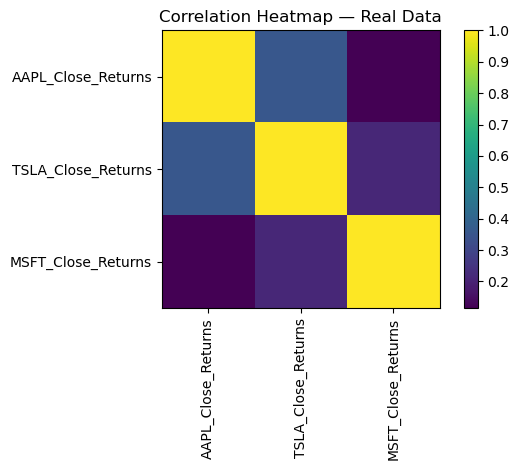

In [228]:
corr1 = df1.corr()
plt.figure()
plt.imshow(corr1)
plt.title("Correlation Heatmap — Real Data")
plt.xticks(range(len(corr1.columns)), corr1.columns, rotation=90)
plt.yticks(range(len(corr1.columns)), corr1.columns)
plt.colorbar()
plt.tight_layout()
plt.show()

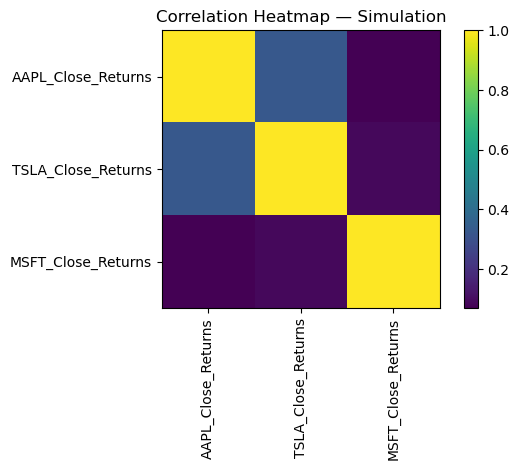

In [229]:
corr2 = df2.corr()
plt.figure()
plt.imshow(corr2)
plt.title("Correlation Heatmap — Simulation")
plt.xticks(range(len(corr2.columns)), corr2.columns, rotation=90)
plt.yticks(range(len(corr2.columns)), corr2.columns)
plt.colorbar()
plt.tight_layout()
plt.show()

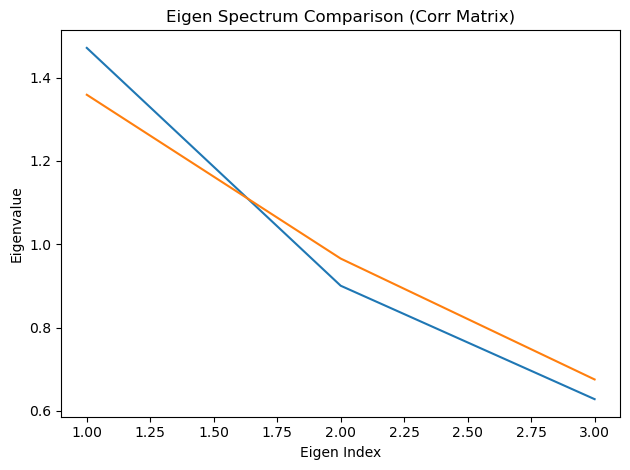

In [230]:
eigvals1, _ = np.linalg.eigh(corr1)
eigvals2, _ = np.linalg.eigh(corr2)

# sort จากใหญ่ไปเล็ก
eigvals1 = np.sort(eigvals1)[::-1]
eigvals2 = np.sort(eigvals2)[::-1]

plt.figure()
plt.plot(range(1, len(eigvals1)+1), eigvals1)
plt.plot(range(1, len(eigvals2)+1), eigvals2)
plt.title("Eigen Spectrum Comparison (Corr Matrix)")
plt.xlabel("Eigen Index")
plt.ylabel("Eigenvalue")
plt.tight_layout()
plt.show()

In [232]:
df1

,AAPL_Close_Returns,TSLA_Close_Returns,MSFT_Close_Returns
0,-0.000666,-0.007051,0.011953
1,0.005508,0.031556,-0.003230
2,0.006137,-0.003525,0.000020
3,0.008996,0.010960,-0.009435
4,-0.001167,0.001354,0.001187
...,...,...,...
59,-0.015700,-0.007206,-0.004679
60,-0.035132,-0.051953,-0.022142
61,0.009697,0.052780,0.006029
62,0.000444,-0.015397,-0.000934


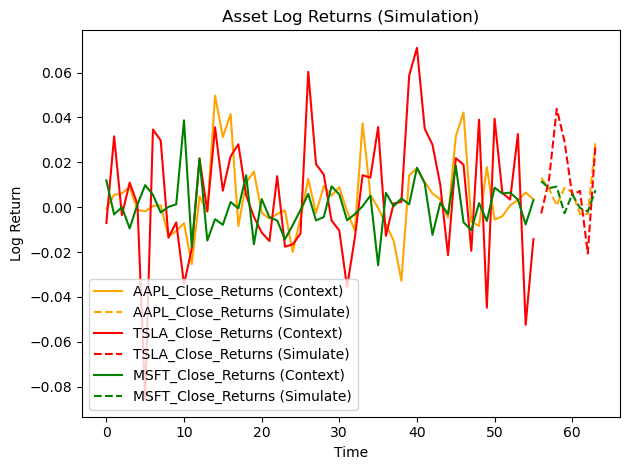

In [240]:
df_early = df2.iloc[:56]   # 56 rows แรก
df_late  = df2.iloc[56:]   # 8 rows หลัง (เพราะ 64 - 56 = 8)

plt.figure()

asset_colors = {
    "AAPL_Close_Returns": "orange",
    "TSLA_Close_Returns": "red",
    "MSFT_Close_Returns": "green"
}

for asset in df2.columns:
    c = asset_colors.get(asset, "black")  # ถ้าไม่เจอใน dict ให้เป็นดำ
    # plot 56 rows แรก (สีชุดแรก)
    plt.plot(df_early.index, df_early[asset], label=f"{asset} (Context)", color=c)
    
    # plot 8 rows หลัง (สีชุดที่สอง)
    plt.plot(df_late.index, df_late[asset], label=f"{asset} (Simulate)", linestyle="--", color=c)

plt.title("Asset Log Returns (Simulation)")
plt.xlabel("Time")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()

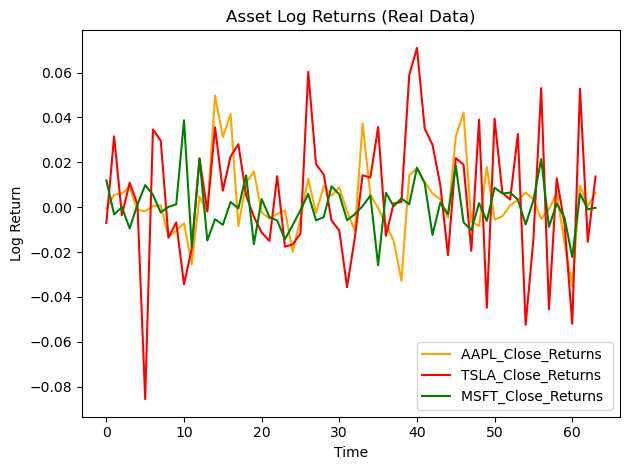

In [242]:
plt.figure()
asset_colors = {
    "AAPL_Close_Returns": "orange",
    "TSLA_Close_Returns": "red",
    "MSFT_Close_Returns": "green"
}
for asset in df1.columns:
    c = asset_colors.get(asset, "black")  # ถ้าไม่เจอใน dict ให้เป็นดำ
    # plot 56 rows แรก (สีชุดแรก)
    plt.plot(df1.index, df1[asset], label=f"{asset} ", color=c)


plt.title("Asset Log Returns (Real Data)")
plt.xlabel("Time")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()

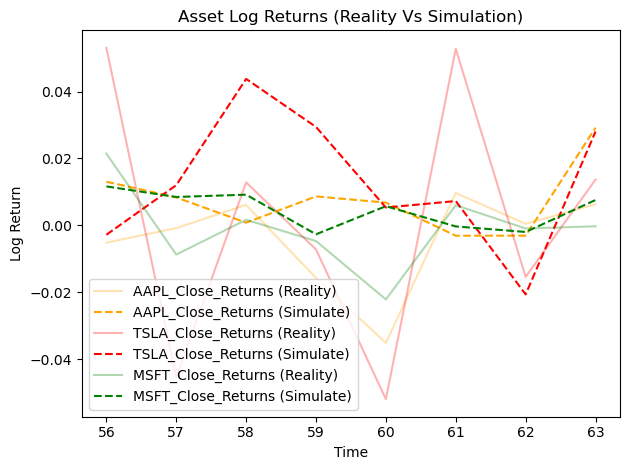

In [245]:
real_df = df1.iloc[56:]   # 56 rows แรก
sim_df  = df2.iloc[56:]   # 8 rows หลัง (เพราะ 64 - 56 = 8)

plt.figure()

asset_colors = {
    "AAPL_Close_Returns": "orange",
    "TSLA_Close_Returns": "red",
    "MSFT_Close_Returns": "green"
}

for asset in df2.columns:
    c = asset_colors.get(asset, "black")  # ถ้าไม่เจอใน dict ให้เป็นดำ
    # plot 56 rows แรก (สีชุดแรก)
    plt.plot(real_df.index, real_df[asset], label=f"{asset} (Reality)", color=c , alpha=0.3)
    
    # plot 8 rows หลัง (สีชุดที่สอง)
    plt.plot(sim_df.index, sim_df[asset], label=f"{asset} (Simulate)", linestyle="--", color=c)

plt.title("Asset Log Returns (Reality Vs Simulation)")
plt.xlabel("Time")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()

In [106]:
col_names = dm.df.columns

l, f = x_real_np.shape
x_real_df = pd.DataFrame(x_real_np.reshape(-1, f), columns=col_names)

l,f = x_pred_np.shape
x_pred_df = pd.DataFrame(x_pred_np.reshape(-1, f), columns=col_names)
print(len(x_real_df), len(x_pred_df))
print(x_real_df.tail(11), x_pred_df.tail(11))

64 64
    AAPL_Close_Returns  TSLA_Close_Returns  MSFT_Close_Returns
53            0.006316            0.013675           -0.000273
54           -0.007609           -0.014817           -0.003551
55            0.019371            0.024331            0.003843
56            0.038681            0.018315            0.006231
57            0.002019           -0.010854            0.001682
58           -0.016577           -0.008235            0.005548
59            0.004363            0.022547            0.000038
60            0.012405           -0.034579            0.005842
61            0.022535            0.042212            0.014994
62            0.000707            0.017810            0.019654
63            0.002599            0.002082           -0.000960     AAPL_Close_Returns  TSLA_Close_Returns  MSFT_Close_Returns
53            0.006316            0.013675           -0.000273
54           -0.007609           -0.014817           -0.003551
55            0.019371            0.024331       

In [107]:
comparison = x_real_df.compare(x_pred_df)
comparison

AAPL_Close_Returns           TSLA_Close_Returns            \
                 self     other               self     other   
63           0.002599  0.005169           0.002082  0.036011   

   MSFT_Close_Returns            
                 self     other  
63           -0.00096  0.000077

In [58]:
features = dm.df.columns
# สร้างพื้นที่กราฟ 3 แถว 1 คอลัมน์
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i in range(3):
    # Plot ตัวแปรที่ 1 (เส้นทึบ)
    axes[i].plot(var1[:, i], label='Variable 1', color='blue', linewidth=2)
    
    # Plot ตัวแปรที่ 2 (เส้นประ) เพื่อให้เห็นความต่างชัดเจนเมื่อทับกัน
    axes[i].plot(var2[:, i], label='Variable 2', color='orange', linestyle='--', linewidth=2, alpha=0.8)
    
    # ตกแต่งกราฟ
    axes[i].set_title(f'Comparison of {features[i]}')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, linestyle=':', alpha=0.6)
    axes[i].legend()

# ใส่ Label แกน X ที่กราฟล่างสุด
axes[2].set_xlabel('Index (0-63)')

plt.tight_layout()
plt.show()

11 (64, 3)


In [17]:
n_sample=64
engine.simulate(n_samples=n_sample, steps_to_predict=1, test_dataloader=test_dataloader)

In [ ]:
def sim(n_sample=64, window):
    enc_true, enc_pred = engine.simulate(n_samples=n_sample, steps_to_predict=1, test_dataloader=test_dataloader)

    
    true_tensor = dm.inverse_transform(enc_true)
    pred_tensor = dm.inverse_transform(enc_pred)
    
    ground_truth_np = true_tensor.to(device).numpy() if torch.is_tensor(true_tensor) else true_tensor 
    pred_np = pred_tensor.to(device).numpy() if torch.is_tensor(pred_tensor) else pred_tensor 
    
    print(f"Pred Shape: pred_np.shape, Groud Truth Shape:{ground_truth_np}")

def sim_to_df(_np):
    b, l, c = _np.shape
    col_names = dm.stats_df.columns

    df = pd.DataFrame(_np.reshape(-1, c), columns=col_names)

    print(f"Num of DF: {len(df)}, Shape: {df.shape}")
    return df

In [25]:
all_predictions = []
all_x_real = []
for batch in test_dataloader:
    x_real = batch[0] if isinstance(batch, list) else batch
    print(x_real.shape)
#     pred_batch = engine.simulate(x_real, steps_to_predict=1)
    
#     all_predictions.append(pred_batch)
#     all_x_real.append(x_real)
    
# final_pred = np.concatenate(all_predictions, axis=0)
# print(f"Evaluated Shape: {final_pred.shape}")

torch.Size([32, 64, 6])
torch.Size([32, 64, 6])
torch.Size([32, 64, 6])
torch.Size([32, 64, 6])
torch.Size([32, 64, 6])
torch.Size([32, 64, 6])
torch.Size([4, 64, 6])


In [33]:
import numpy as np

def generate_rolling_forecast(engine, initial_batch, n_steps):
    """
    Generate long sequences using the engine.simulate function in a loop.
    
    Args:
        engine: Object ที่มี method .simulate()
        initial_batch: Numpy array or Tensor (Batch, 64, 6)
        n_steps: จำนวนวันที่ต้องการทำนายเพิ่ม (เช่น 252 วัน)
        
    Returns:
        generated_path: Numpy array (Batch, n_steps, 6)
    """
    # เตรียมข้อมูลเริ่มต้น (แปลงเป็น Numpy เพื่อจัดการ Array ง่ายๆ ในลูป)
    # ถ้า initial_batch เป็น Tensor ก็แปลงก่อน, ถ้าเป็น list ก็แปลง
    if hasattr(initial_batch, 'cpu'):
        current_x = initial_batch.cpu().numpy()
    elif isinstance(initial_batch, list):
        current_x = np.array(initial_batch)
    else:
        current_x = initial_batch.copy() # (Batch, 64, 6)
        
    generated_data = [] # เก็บผลลัพธ์ทีละ step
    
    print(f"Starting simulation for {n_steps} steps...")
    
    for i in range(n_steps):
        # 1. เรียกใช้ simulate เดิมของคุณ (Inpaint 1 step สุดท้าย)
        # ผลลัพธ์ filled_window จะออกมาเป็น Numpy (Batch, 64, 6) ตามโค้ดคุณ
        filled_window = engine.simulate(current_x, steps_to_predict=1)
        
        # 2. ดึงเฉพาะ Step สุดท้ายที่ Model เพิ่ง Gen ออกมา
        # filled_window shape: (Batch, 64, 6)
        # เราเอา [:, -1:, :] จะได้ shape (Batch, 1, 6)
        newest_step = filled_window[:, -1:, :] 
        
        # 3. เก็บใส่ list ไว้
        generated_data.append(newest_step)
        
        # 4. Update Window (Sliding)
        # ตัดตัวแรกออก (index 0) แล้วเอา newest_step ต่อท้าย
        # current_x[:, 1:, :] คือ (Batch, 63, 6)
        # newest_step คือ (Batch, 1, 6)
        # รวมกันกลับมาเป็น (Batch, 64, 6) เหมือนเดิม พร้อมเข้าลูปใหม่
        current_x = np.concatenate([current_x[:, 1:, :], newest_step], axis=1)
        
        # (Optional) Print progress ทุกๆ 10 steps
        if (i+1) % 50 == 0:
            print(f"Generated {i+1}/{n_steps} steps")

    # 5. รวมผลลัพธ์ทั้งหมด
    # จะได้ Array ก้อนใหญ่ (Batch, n_steps, 6)
    full_path = np.concatenate(generated_data, axis=1)

    return full_path

In [35]:
test_batch = next(iter(test_dataloader)) # (32, 64, 6)
simulated_paths = generate_rolling_forecast(engine, test_batch, n_steps=4)

INFO:root:Starting In-painting/Forecasting for 64 samples...


Starting simulation for 4 steps...


In-painting: 100%|██████████| 999/999 [00:02<00:00, 337.19it/s]
INFO:root:Starting In-painting/Forecasting for 64 samples...
In-painting: 100%|██████████| 999/999 [00:02<00:00, 337.51it/s]
INFO:root:Starting In-painting/Forecasting for 64 samples...
In-painting: 100%|██████████| 999/999 [00:02<00:00, 337.33it/s]
INFO:root:Starting In-painting/Forecasting for 64 samples...
In-painting: 100%|██████████| 999/999 [00:02<00:00, 336.93it/s]


In [36]:
print("Simulation Shape:", simulated_paths.shape)

Simulation Shape: (2, 4, 64, 6)


In [39]:
log_returns_gen = simulated_paths[:, :, :3]
log_returns_gen.shape

(2, 4, 3, 6)

In [47]:
def compare_gen_vs_real(engine, raw_data, start_index, n_steps=30, window_size=64):
    """
    ดึงข้อมูลจริงมาเทียบกับที่ Gen แบบจุดต่อจุด
    
    Args:
        engine: Object ที่มี .simulate()
        raw_data: ข้อมูลดิบทั้งหมด (N, 6) -> ควรเป็น Numpy array
        start_index: จุดเริ่มต้นใน raw_data ที่จะเริ่มตัด Window
        n_steps: จำนวนวันที่ต้องการทำนายล่วงหน้า
    """
    # 1. เตรียมข้อมูล
    # Context (อดีต): เอาไว้ป้อน Model
    context_data = raw_data[start_index : start_index + window_size] # (64, 6)
    
    # Ground Truth (อนาคตของจริง): เอาไว้ตรวจคำตอบ
    real_future = raw_data[start_index + window_size : start_index + window_size + n_steps] # (n_steps, 6)
    
    # แปลง Shape ให้เข้า Model (Batch=1, 64, 6)
    context_batch = context_data.reshape(1, window_size, -1)
    
    # 2. ให้ Model ทำนาย (Simulate)
    # ใช้ฟังก์ชัน generate_rolling_forecast ที่เราเพิ่งแก้เมื่อกี้
    gen_future = generate_rolling_forecast(engine, context_batch, n_steps) # (1, n_steps, 6)
    gen_future = gen_future[0] # ดึง Batch แรกออกมา -> (n_steps, 6)
    
    # --- ส่วน Visualization (เทียบ 3 Assets แรก) ---
    features_to_plot = 3 # สมมติว่า 3 ตัวแรกคือ Log Returns
    fig, axes = plt.subplots(features_to_plot, 1, figsize=(10, 12), sharex=True)
    
    time_past = range(window_size)
    time_future = range(window_size, window_size + n_steps)
    
    for i in range(features_to_plot):
        # Plot อดีต
        axes[i].plot(time_past, context_data[:, i], color='gray', label='History (Context)')
        
        # Plot อนาคต (ของจริง vs ที่ Gen มา)
        axes[i].plot(time_future, real_future[:, i], color='green', label='Real Future', linestyle='--')
        axes[i].plot(time_future, gen_future[:, i], color='red', label='Generated Future')
        
        axes[i].set_title(f'Asset {i+1} Log Returns')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

    # --- ส่วน Compare Covariance (ตามแผนข้อ 7) ---
    # คำนวณ Covariance ของช่วง Future เท่านั้น
    cov_real = np.cov(real_future[:, :3].T)
    cov_gen = np.cov(gen_future[:, :3].T)
    
    print("\n--- Covariance Comparison ---")
    print("Real Future Covariance:\n", np.round(cov_real, 5))
    print("\nGenerated Future Covariance:\n", np.round(cov_gen, 5))
    
    # คำนวณความต่าง (Frobenius Norm)
    diff_norm = np.linalg.norm(cov_real - cov_gen)
    print(f"\nCovariance Distance (Frobenius Norm): {diff_norm:.5f}")

In [48]:
# สมมติ data_test_np คือข้อมูล Test set ทั้งก้อน shape (T, 6)
# เลือกจุด start แบบสุ่ม หรือกำหนดเอง
start_idx = 100 

# เรียกฟังก์ชันเทียบดูเลย! (ทำนายไป 50 วัน)
compare_gen_vs_real(engine, test_batch, start_index=start_idx, n_steps=8)

NameError: name 'data_test_np' is not defined